In [40]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from oggm import utils

import xesmf as xe

import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size


import seaborn as sns

In [10]:
base_url = 'https://atmos.washington.edu/%7Ehakim/lmr/LMRv2/'
fpath_temp = utils.file_downloader(base_url + 'air_MCruns_ensemble_mean_LMRv2.1.nc')

In [25]:
with xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.1/era5_monthly_t2m_1979-2019.nc') as dse:
    dse = dse.resample(time='AS').mean(dim='time')

In [26]:
with xr.open_dataset(fpath_temp) as ds:
    air = ds.air.mean(dim='MCrun')

In [27]:
sel = air.sel(time=slice('0001', '0031')).mean(dim='time')

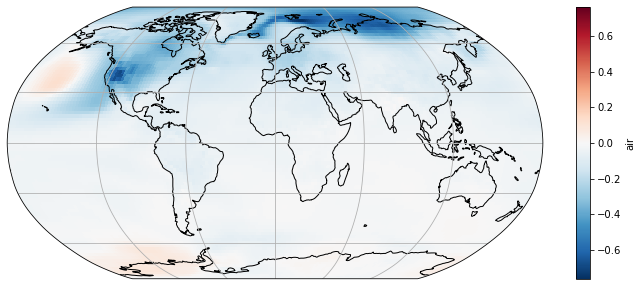

In [28]:
plt.figure();
ax = plt.axes(projection=ccrs.Robinson())
sel.plot.imshow(ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines(); ax.gridlines(); # Add gridlines and coastlines to the plot
plt.title(f'');

In [29]:
weight = np.cos(np.deg2rad(air.lat))
weight = weight / weight.sum()
ts = (air.mean(dim='lon') * weight).sum(dim='lat')

In [30]:
ts['time'] = ('time', np.arange(len(ts['time'])))

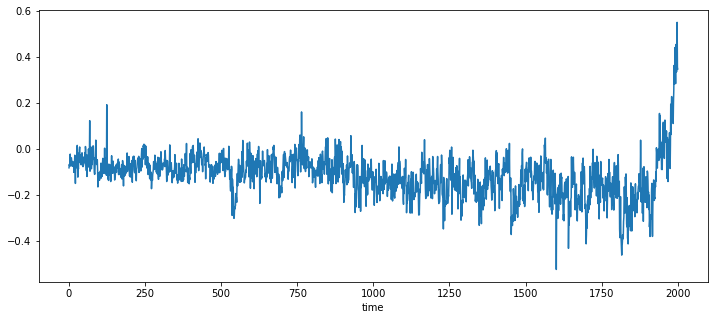

In [31]:
ts.plot();

## Put it on ERA grid cause I'm lazy 

In [33]:
regridder = xe.Regridder(air, dse, method='bilinear', periodic=True)
re_air = regridder(air)

/home/users/fmaussion/.miniconda3/envs/oggm_env/lib/python3.8/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/users/fmaussion/.miniconda3/envs/oggm_env/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [34]:
sel = re_air.sel(time=slice('0001', '0031')).mean(dim='time')

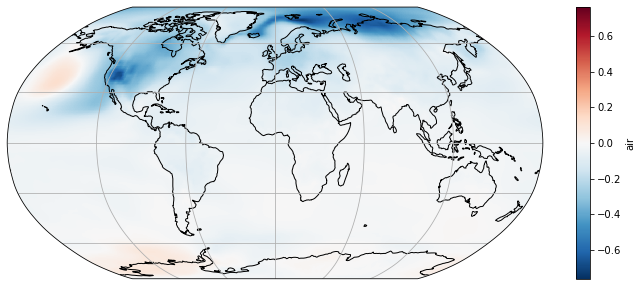

In [35]:
plt.figure();
ax = plt.axes(projection=ccrs.Robinson())
sel.plot.imshow(ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines(); ax.gridlines(); # Add gridlines and coastlines to the plot
plt.title(f'');

## Check trends per reg 

In [36]:
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf = pd.read_hdf(frgi)

In [37]:
nx, ny = dse.dims['longitude'], dse.dims['latitude']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon'])
# This is ERA5 specific!!! Needs to be done on the GCM grid
lon_bins = np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of ERA5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

Total number of glaciers: 216502 and number of ERA5 gridpoints with glaciers in them: 11323


In [38]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area']
dse['glacier_mask'] = (('latitude', 'longitude'), np.isfinite(mask))
dse['glacier_area'] = (('latitude', 'longitude'), mask)
dse['weight_glacier'] = (('latitude', 'longitude'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
dse['rgi_region'] = (('latitude', 'longitude'), reg)

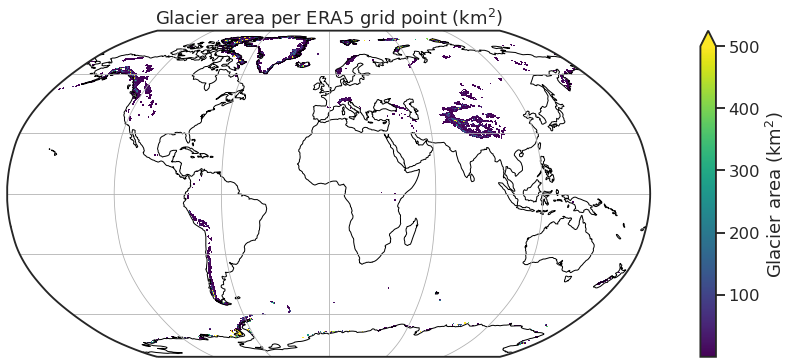

In [41]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per ERA5 grid point (km$^{2}$)');

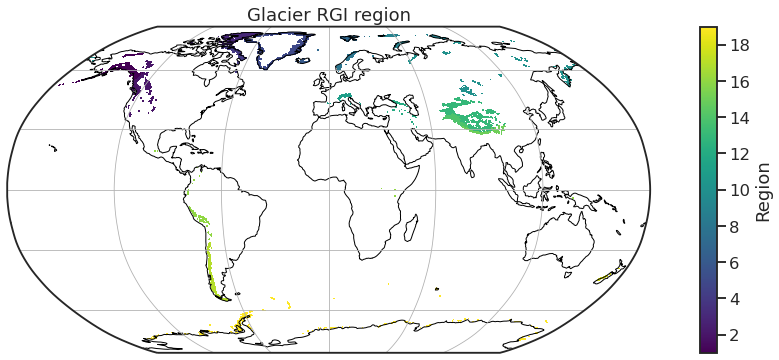

In [42]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['rgi_region'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            cbar_kwargs={'label':'Region'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier RGI region');

In [43]:
# Weight
weight = np.cos(np.deg2rad(dse.latitude.astype(np.float64))).clip(0)
weight =  dse.t2m.isel(time=0) * 0. + weight
dse['weight'] = (('latitude', 'longitude'), weight / weight.sum())

## region averages at glacier locs

In [27]:
agg = xr.open_dataset('cmip_dt_per_dt.nc')
agg_pr = xr.open_dataset('cmip_dp_per_dt.nc')

In [28]:
tdf = pd.DataFrame(dtype=float)
# Check (should be one)
tdf.loc['GMT', 'ALL'] = float((agg[f'cmip_avg'] * dse.weight).sum(dim=['longitude','latitude']))
# All glaciers
tdf.loc['All', 'ALL'] = float((agg[f'cmip_avg'] * dse.weight_glacier).sum(dim=['longitude','latitude']))

for member in agg.member.data:
    s = agg['cmip_all'].isel(member=[m == member for m in agg.member.data]).isel(member=0)
    tdf.loc['GMT', member] = float((s * dse.weight).sum(dim=['longitude','latitude']))
    tdf.loc['All', member] = float((s * dse.weight_glacier).sum(dim=['longitude','latitude']))

for rgi_reg in range(1, 20):
    weight_reg = dse.weight_glacier.where(dse.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    
    tdf.loc['RGI {:02d}'.format(rgi_reg), 'ALL'] = float((agg[f'cmip_avg'] * weight_reg).sum(dim=['longitude','latitude']))
    
    for member in agg.member.data:
        s = agg['cmip_all'].isel(member=[m == member for m in agg.member.data]).isel(member=0)
        tdf.loc['RGI {:02d}'.format(rgi_reg), member] = float((s * weight_reg).sum(dim=['longitude','latitude']))

In [29]:
yerr = tdf[[c for c in tdf.columns[1:]]].std(axis=1)